# Transformers

In this assignment, you will build and train a neural network for text classification using PyTorch. You will start by preprocessing text data, constructing a vocabulary, and encoding sentences into numerical representations. Using this processed data, you will implement key components of a Transformer-based model, including positional encoding, multi-head attention, and a feedforward network.

Through this assignment, you will:

- Develop a text preprocessing pipeline, including tokenization and vocabulary construction.
- Implement custom dataset classes to handle text data efficiently in PyTorch.
- Gain a deeper understanding of self-attention mechanisms and their role in modern NLP architectures.
- Train and evaluate a Transformer-like model for spam classification.
- Explore the impact of key hyperparameters on model performance.
- By the end, you will have hands-on experience with text-based deep learning, helping you understand how Transformers process and classify textual inputs.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import re

# The text preprocessor

The TextPreprocessor class is a fundamental component for natural language processing tasks, designed to transform raw text into a format suitable for machine learning models. This preprocessor handles several critical text processing steps including tokenization, vocabulary building, and encoding sequences to fixed-length numeric representations.


In [2]:
class TextPreprocessor:
    def __init__(self, max_vocab_size=10000, max_seq_length=128):
        # Initialize maximum vocabulary size (default 10000 words)
        self.max_vocab_size = max_vocab_size
        # Set maximum sequence length for padded outputs (default 128 tokens)
        self.max_seq_length = max_seq_length
        # Initialize word-to-index mapping with special tokens PAD (0) and UNK (1)
        #self.word2idx = #TODO
        # your code here
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        
        # Initialize index-to-word mapping with special tokens
        #self.idx2word = #TODO
        # your code here
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        
        # Initialize Counter object to track word frequencies
        self.word_freq = Counter()

    def tokenize(self, text):
        # Convert input text to lowercase for consistency
        #text = #TODO
        # your code here
        text = text.lower()
        
        # Remove special characters while preserving basic punctuation
        # text = #TODO
        # your code here
        text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
        
        # Split text into individual tokens
        return text.split()

    def build_vocab(self, texts):
        # Iterate through all texts and count word frequencies
        for text in texts:
            self.word_freq.update(self.tokenize(text))

        # Sort words by frequency and keep top max_vocab_size-2 words
        # vocab_words = #TODO
        # your code here
        vocab_words = self.word_freq.most_common(self.max_vocab_size - 2)
        
        vocab_words = vocab_words[:self.max_vocab_size-2]  # Reserve space for PAD and UNK

        # Create mappings between words and indices for the vocabulary
        for word, _ in vocab_words:
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    def encode(self, text):
        # Convert text to tokens
        # tokens = #TODO
        # your code here
        tokens = self.tokenize(text)
        
        # Truncate sequence if longer than max_seq_length
        # tokens = #TODO
        # your code here
        tokens = tokens[:self.max_seq_length]
        
        # Pad sequence with PAD tokens if shorter than max_seq_length
        # tokens = #TODO
        # your code here
        while len(tokens) < self.max_seq_length:
            tokens.append('<PAD>')
        
        # Convert tokens to indices, using UNK for unknown words
        return [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]


In [3]:
# Test for text tokenization
processor = TextPreprocessor()
text = "Hello, World! This is a TEST."
tokens = processor.tokenize(text)
assert all(t.islower() for t in tokens), "Tokens should be lowercase"
assert ',' not in tokens and '!' not in tokens, "Special characters should be removed"
assert "hello" in tokens and "is" in tokens and "test" in tokens, "Words should be properly tokenized"

In [4]:
# Test for vocabulary building
processor = TextPreprocessor(max_vocab_size=5)  # PAD, UNK + 3 words
sample_texts = ["hello world", "hello test", "world test test"]
processor.build_vocab(sample_texts)
assert len(processor.word2idx) == 5, "Vocabulary size should respect max_vocab_size"
assert '<PAD>' in processor.word2idx and '<UNK>' in processor.word2idx, "Special tokens should be in vocabulary"
assert 'test' in processor.word2idx, "'test' should be in vocabulary (most frequent)"
assert 'hello' in processor.word2idx, "'hello' should be in vocabulary"
assert 'world' in processor.word2idx, "'world' should be in vocabulary"

In [5]:
# Test for text encoding
processor = TextPreprocessor(max_seq_length=5)
processor.word2idx = {'<PAD>': 0, '<UNK>': 1, 'hello': 2, 'world': 3}
processor.idx2word = {0: '<PAD>', 1: '<UNK>', 2: 'hello', 3: 'world'}

# Test case for truncation
encoded = processor.encode("hello world hello world hello world")
assert len(encoded) == 5, "Sequence should be truncated to max_seq_length"
assert encoded == [2, 3, 2, 3, 2], "Sequence should be properly encoded"

# Test case for padding
encoded = processor.encode("hello world")
assert len(encoded) == 5, "Sequence should be padded to max_seq_length"
assert encoded == [2, 3, 0, 0, 0], "Sequence should be padded with PAD tokens"

# Test case for unknown tokens
encoded = processor.encode("hello test")
assert encoded == [2, 1, 0, 0, 0], "Unknown words should be encoded as UNK token"

The class is particularly important because it handles several crucial preprocessing steps that are essential for most NLP tasks. The tokenization process breaks down text into meaningful units while removing unnecessary characters. The vocabulary building functionality ensures that the most frequent words are retained while managing vocabulary size constraints, which is crucial for model efficiency and memory management. The encoding process converts variable-length text sequences into fixed-length numeric sequences that can be processed by neural networks.

What makes this class especially valuable is its handling of edge cases through special tokens: '<PAD>' for maintaining consistent sequence lengths and '<UNK>' for handling out-of-vocabulary words. These features make it robust and suitable for real-world applications where text input can be highly variable and unpredictable.

The class supports customization through its parameters (max_vocab_size and max_seq_length), making it adaptable to different requirements and hardware constraints.

Let us now define a class for our ham/spam dataset. The class is provided to you directly - no changes are required.

In [6]:
class SpamDataset(Dataset):
    def __init__(self, texts, labels, preprocessor):
        self.encoded_texts = [preprocessor.encode(text) for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (torch.tensor(self.encoded_texts[idx], dtype=torch.long),
                torch.tensor(self.labels[idx], dtype=torch.long))

# What are positional encodings?

The PositionalEncoding class is a crucial component in transformer-based architectures, designed to inject information about the relative or absolute position of tokens in a sequence. This positional information is essential because transformer models process input tokens in parallel, which means they have no inherent way to understand the order of the sequence. Without positional encoding, a transformer would treat "The cat sat on the mat" and "The mat sat on the cat" as equivalent sequences.


In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=512):
        super().__init__()

        # Create matrix of shape [max_seq_length, d_model]
        #pe = #TODO
        # your code here
        pe = torch.zeros(max_seq_length, d_model)
        
        # Create position vector [max_seq_length, 1]
        # position = #TODO
        # your code here
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        
        # Create division term [d_model/2]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices
        # pe[:, 0::2] = #TODO
        # your code here
        pe[:, 0::2] = torch.sin(position * div_term)
        
        # Apply cosine to odd indices
        # pe[:, 1::2] = #TODO
        # your code here
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension [1, max_seq_length, d_model]
        pe = pe.unsqueeze(0)

        # Register as buffer (won't be trained)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: [batch_size, seq_length, d_model]
        return x + self.pe[:, :x.size(1)]


In [8]:
# Test for positional encoding
import torch
import math

d_model = 64
max_seq_length = 10
pe = torch.zeros(max_seq_length, d_model)
position = torch.arange(0, max_seq_length).unsqueeze(1).float()
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

# Test computation of positional encoding
assert pe.shape == (max_seq_length, d_model), "PE matrix should have shape [max_seq_length, d_model]"
assert position.shape == (max_seq_length, 1), "Position vector should have shape [max_seq_length, 1]"

# Apply sine to even indices
pe_test = pe.clone()
pe_test[:, 0::2] = torch.sin(position * div_term)
assert not torch.allclose(pe_test, torch.zeros_like(pe_test)), "Sine values should be non-zero"
assert torch.all((pe_test[:, 0::2] >= -1) & (pe_test[:, 0::2] <= 1)), "Sine values should be between -1 and 1"

# Apply cosine to odd indices
pe_test = pe.clone()
pe_test[:, 1::2] = torch.cos(position * div_term)
assert not torch.allclose(pe_test, torch.zeros_like(pe_test)), "Cosine values should be non-zero"
assert torch.all((pe_test[:, 1::2] >= -1) & (pe_test[:, 1::2] <= 1)), "Cosine values should be between -1 and 1"

The positional encoding follows a specific pattern using sine and cosine functions of different frequencies. This creates a unique encoding for each position that the model can learn to interpret. The encoding is deterministic and has several important properties:

1. It allows the model to learn relative positions between tokens at different scales
2. It has a bounded range, which helps with training stability
3. The pattern can theoretically extend to sequences longer than those seen during training
4. It creates unique patterns that vary smoothly with position

The forward method simply adds these position encodings to the input embeddings. This addition is possible because the encodings are designed to have the same dimensionality as the token embeddings. The use of both sine and cosine functions allows the model to attend to relative positions through linear combinations of these values.

# Understanding multi-head attention

The MultiHeadAttention class is a fundamental component of transformer architectures that enables the model to attend to different parts of the input sequence simultaneously. This mechanism allows the model to capture various types of relationships and patterns in the data at different representation subspaces. The multi-head approach splits the attention computation into several parallel heads, each focusing on different aspects of the input.

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        # How do you compute d_k?
        #self.d_k = #TODO
        # your code here
        self.d_k = d_model // num_heads
        
        # Linear layers for Q, K, V projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Output projection
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q, K, V shapes: [batch_size, num_heads, seq_length, d_k]
        # Calculate attention scores
        # scores = #TODO
        # your code here
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax to get attention weights
        # attention_weights = #TODO
        # your code here
        attention_weights = F.softmax(scores, dim=-1)

        # Calculate output - remember that you need to multiply attention weights and values
        # output = #TODO
        # your code here
        output = torch.matmul(attention_weights, V)
        
        return output, attention_weights

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)

        # Linear projections and reshape
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Calculate attention using scaled dot product with updated Q, K, V values
        # output, attention_weights = #TODO
        # your code here
        output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        # Reshape and apply output projection
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(output)

        return output, attention_weights


In [10]:
# Test for d_k computation in MultiHeadAttention
d_model = 64
num_heads = 8
multi_head_attention = MultiHeadAttention(d_model, num_heads)
assert multi_head_attention.d_k == 8, "d_k should be d_model / num_heads"

d_model = 128
num_heads = 4
multi_head_attention = MultiHeadAttention(d_model, num_heads)
assert multi_head_attention.d_k == 32, "d_k should be d_model / num_heads"

In [11]:
# Test scaled_dot_product_attention
d_model = 64
num_heads = 8
d_k = d_model // num_heads
batch_size = 2
seq_length = 4

Q = torch.randn(batch_size, num_heads, seq_length, d_k)
K = torch.randn(batch_size, num_heads, seq_length, d_k)
V = torch.randn(batch_size, num_heads, seq_length, d_k)

multi_head_attention = MultiHeadAttention(d_model, num_heads)

# Test for scores calculation
scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
assert scores.shape == (batch_size, num_heads, seq_length, seq_length), "Attention scores shape is incorrect"

# Test for softmax application
attention_weights = torch.nn.functional.softmax(scores, dim=-1)
assert attention_weights.shape == (batch_size, num_heads, seq_length, seq_length), "Attention weights shape is incorrect"
assert torch.allclose(attention_weights.sum(dim=-1), torch.ones(batch_size, num_heads, seq_length)), "Softmax weights should sum to 1"

# Test for output calculation
output = torch.matmul(attention_weights, V)
assert output.shape == (batch_size, num_heads, seq_length, d_k), "Output shape is incorrect"

# Defining the transformer block

The FeedForward class implements a position-wise feed-forward network that applies two linear transformations with a ReLU activation in between. This component is crucial because it introduces non-linearity into the model and allows it to process the attention outputs further. The network typically expands the input dimension (d_model) to a larger intermediate dimension (d_ff) and then projects it back, enabling it to capture more complex patterns in the data.
The TransformerBlock class combines all the essential components of a transformer layer into a single module. It implements the core transformer architecture with several important features:

1. Multi-head attention for capturing relationships between different positions in the sequence
2. Position-wise feed-forward network for additional processing
3. Layer normalization for stable training
4. Residual connections to prevent degradation in deep networks
5. Dropout for regularization

In [12]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        # Inherit from PyTorch's Module class
        super().__init__()
        # First linear transformation that expands the dimension
        self.linear1 = nn.Linear(d_model, d_ff)
        # Second linear transformation that projects back to original dimension
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # Apply first linear transform, ReLU activation, and second linear transform
        # This creates a non-linear transformation of the input
        return self.linear2(F.relu(self.linear1(x)))


class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        # Inherit from PyTorch's Module class
        super().__init__()

        # Initialize multi-head attention mechanism
        self.attention = MultiHeadAttention(d_model, num_heads)
        # Initialize position-wise feed-forward network
        self.feed_forward = FeedForward(d_model, d_ff)

        # Layer normalization for attention output
        # self.norm1 = #TODO
        # your code here
        self.norm1 = nn.LayerNorm(d_model)
        
        # Layer normalization for feed-forward output
        # self.norm2 = #TODO
        # your code here
        self.norm2 = nn.LayerNorm(d_model)

        # Dropout for regularization - add the dropout layer
        # self.dropout = #TODO
        # your code here
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Apply multi-head attention with residual connection and normalization
        attention_output, _ = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attention_output))

        # Apply feed-forward network with residual connection and normalization
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x


In [13]:
# Test for MultiHeadAttention forward method
d_model = 64
num_heads = 8
multi_head_attention = MultiHeadAttention(d_model, num_heads)

batch_size = 2
seq_length = 4
Q = torch.randn(batch_size, seq_length, d_model)
K = torch.randn(batch_size, seq_length, d_model)
V = torch.randn(batch_size, seq_length, d_model)

output, attention_weights = multi_head_attention.scaled_dot_product_attention(
    multi_head_attention.W_q(Q).view(batch_size, -1, num_heads, d_model // num_heads).transpose(1, 2),
    multi_head_attention.W_k(K).view(batch_size, -1, num_heads, d_model // num_heads).transpose(1, 2),
    multi_head_attention.W_v(V).view(batch_size, -1, num_heads, d_model // num_heads).transpose(1, 2)
)

assert output.shape == (batch_size, num_heads, seq_length, d_model // num_heads), "Output shape is incorrect"
assert attention_weights.shape == (batch_size, num_heads, seq_length, seq_length), "Attention weights shape is incorrect"

The forward pass of the TransformerBlock processes the input through these components in sequence, with each step building upon the previous one. The use of residual connections (implemented through addition operations) helps gradient flow during training and allows the model to maintain access to lower-level features. The layer normalization after each sub-layer helps stabilize the learning process by normalizing the activations, while dropout helps prevent overfitting by randomly zeroing out some connections during training.
Together, these components create a powerful building block that can be stacked multiple times to create deep transformer networks capable of processing complex sequential data across various domains, from natural language processing to computer vision.

# Adapting this architecture to our classification task

The SpamTransformer class implements a complete transformer-based model specifically designed for spam detection tasks. This implementation combines all the previously discussed components into a cohesive architecture that can learn to distinguish between spam (unwanted) and ham (legitimate) messages.

In [14]:
class SpamTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_length):
        # Inherit from PyTorch's Module class
        super().__init__()

        # Create embedding layer to convert token IDs to dense vectors
        # Maps each token in vocabulary to a d_model dimensional vector
        self.embedding = nn.Embedding(vocab_size, d_model)

        # Add positional encoding to provide position information
        # This helps the model understand token ordering
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # Create stack of transformer blocks
        # Each block contains multi-head attention and feed-forward network
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ])

        # Final classification layer
        # Projects to 2 dimensions for binary classification (spam/ham)
        self.final_layer = nn.Linear(d_model, 2)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, mask=None):
        # Convert input tokens to embeddings and add positional encoding
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        # Pass input through each transformer block sequentially
        # Each block processes and refines the sequence representation
        for block in self.transformer_blocks:
            x = block(x, mask)

        # Average pooling across sequence length
        # This creates a fixed-size representation of the entire sequence
        x = torch.mean(x, dim=1)

        # Final classification
        # Projects to logits for spam/ham classification
        x = self.final_layer(x)
        return x

In [15]:
# Test for TransformerBlock layer normalization and dropout
d_model = 64
num_heads = 8
d_ff = 256
dropout_rate = 0.1

# Test layer normalization initialization
layer_norm = torch.nn.LayerNorm(d_model)
assert layer_norm.normalized_shape == (d_model,), "Layer norm should normalize over d_model dimension"

# Test dropout initialization
dropout = torch.nn.Dropout(dropout_rate)
assert dropout.p == dropout_rate, "Dropout probability should match the input rate"

# Test in the context of a transformer block
transformer_block = TransformerBlock(d_model, num_heads, d_ff, dropout_rate)
assert isinstance(transformer_block.norm1, torch.nn.LayerNorm), "norm1 should be a LayerNorm instance"
assert isinstance(transformer_block.norm2, torch.nn.LayerNorm), "norm2 should be a LayerNorm instance"
assert isinstance(transformer_block.dropout, torch.nn.Dropout), "dropout should be a Dropout instance"
assert transformer_block.dropout.p == dropout_rate, "Dropout rate should be set correctly"

Let's understand what is going on with the transformer architecture here:
- The embedding layer converts discrete tokens into continuous vectors, allowing the model to learn semantic relationships between words.
- The positional encoding ensures the model can understand the sequence order of tokens, which is crucial for understanding message context.
- The stack of transformer blocks enables the model to process the input at multiple levels of abstraction, capturing both local and global patterns in the text.
- Global average pooling creates a fixed-size representation of the entire message, regardless of its length, which is then used for classification.
The final linear layer produces logits for binary classification, which can be converted to probabilities using softmax.

Hopefully, through this exercise you can see how transformers can:

- Handle variable-length input sequences
- Capture complex relationships between words and phrases
- Learn patterns at different scales through their multi-layer structure
- Maintain position sensitivity while processing tokens in parallel
- Prevent overfitting by using dropout layers

# Training and evaluation

These functions form the core training loop for the spam detection transformer. The create_attention_mask function generates a simple attention mask that allows all positions to attend to all other positions. We don't mask padded tokens here, but that could be an option in a more complex task or a production setting.

The train_epoch() function handles training for one entire epoch. You should be able to figure out how the rest of this notebook works as you are familiar with training and evaluation at this point.

In [16]:
def create_attention_mask(seq_length):
    # Create a square matrix of ones with dimensions [seq_length, seq_length]
    # This mask allows each position to attend to all other positions
    # In a more complex implementation, this could be modified to mask padding tokens
    # mask = #TODO
    # your code here
    mask = torch.ones(seq_length, seq_length)
    
    return mask


def train_epoch(model, dataloader, criterion, optimizer, device):
    # Set model to training mode - enables dropout, batch normalization, etc.
    model.train()

    # Initialize tracking variables for loss and accuracy
    total_loss = 0
    correct = 0
    total = 0

    # Iterate through batches in the dataloader
    for batch_idx, (data, target) in enumerate(dataloader):
        # Move data and target tensors to specified device (CPU/GPU)
        data, target = data.to(device), target.to(device)

        # Create attention mask for the current batch
        mask = create_attention_mask(data.size(1)).to(device)

        # Clear gradients from previous batch
        #TODO
        optimizer.zero_grad()

        # Forward pass: compute model predictions
        #TODO
        output = model(data, mask)

        # Calculate loss between predictions and targets
        # loss = #TODO
        loss = criterion(output, target)

        # Backward pass: compute gradients
        #TODO
        loss.backward()

        # Update model parameters using optimizer
        #TODO
        optimizer.step()

        # Accumulate total loss for epoch
        # total_loss += #TODO
        # your code here
        total_loss += loss.item()

        # Calculate and accumulate accuracy statistics
        # pred = #TODO  # Get predicted class using argmax
        # your code here
        pred = output.argmax(dim=1)
        
        correct += pred.eq(target).sum().item()  # Count correct predictions
        total += target.size(0)  # Count total predictions

        # Print progress every 50 batches
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

    # Return average loss and accuracy for the epoch
    return total_loss / len(dataloader), correct / total


In [17]:
# Test for create_attention_mask function
seq_length = 5
mask = torch.ones(seq_length, seq_length)
assert mask.shape == (seq_length, seq_length), "Mask shape should be [seq_length, seq_length]"
assert torch.all(mask == 1), "All values in the mask should be 1"

# Test for optimizer operations in train_epoch
model = SpamTransformer(vocab_size=100, d_model=64, num_heads=4, d_ff=256, num_layers=2, max_seq_length=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Test for optimizer.zero_grad()
initial_grads = [param.grad for param in model.parameters() if param.grad is not None]
optimizer.zero_grad()
after_zero_grads = [param.grad for param in model.parameters() if param.grad is not None]
assert len(after_zero_grads) == 0, "All gradients should be None after zero_grad()"

# Create dummy data
batch_size = 2
seq_length = 10
data = torch.randint(0, 100, (batch_size, seq_length))
target = torch.randint(0, 2, (batch_size,))

# Test for forward pass
output = model(data)
assert output.shape == (batch_size, 2), "Output shape should be [batch_size, num_classes]"

# Test for loss calculation
loss = criterion(output, target)
assert isinstance(loss, torch.Tensor), "Loss should be a tensor"
assert loss.requires_grad, "Loss should require gradients"

# Test for backward pass
loss.backward()
has_grad = [param.grad is not None for param in model.parameters()]
assert all(has_grad), "All parameters should have gradients after backward()"

# Test for optimizer step
old_params = [param.clone().detach() for param in model.parameters()]
optimizer.step()
new_params = [param.clone().detach() for param in model.parameters()]
assert any(not torch.allclose(old, new) for old, new in zip(old_params, new_params)), "Parameters should change after optimizer step"

In [18]:
def evaluate(model, dataloader, criterion, device):
    # Set model to evaluation mode - disables dropout, batch normalization, etc.
    model.eval()
    # Initialize tracking variables
    total_loss = 0
    correct = 0
    total = 0

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for data, target in dataloader:
            # Move data to appropriate device
            data, target = data.to(device), target.to(device)
            # Create attention mask for current batch
            # mask = #TODO
            # your code here
            mask = create_attention_mask(data.size(1)).to(device)

            # Forward pass
            # output = #TODO
            # your code here
            output = model(data, mask)
            
            # Calculate loss
            # loss = #TODO
            # your code here
            loss = criterion(output, target)
            
            # Accumulate loss and accuracy metrics
            total_loss += loss.item()
            # pred = #TODO # use argmax
            # your code here
            pred = output.argmax(dim=1)
            
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    # Return average loss and accuracy
    return total_loss / len(dataloader), correct / total


In [19]:
# Test for evaluate function components
model = SpamTransformer(vocab_size=100, d_model=64, num_heads=4, d_ff=256, num_layers=2, max_seq_length=10)
criterion = torch.nn.CrossEntropyLoss()

# Create dummy data
batch_size = 2
seq_length = 10
data = torch.randint(0, 100, (batch_size, seq_length))
target = torch.randint(0, 2, (batch_size,))

# Test for attention mask creation
mask = torch.ones(seq_length, seq_length)
assert mask.shape == (seq_length, seq_length), "Mask shape should be [seq_length, seq_length]"

# Test for model output
model.eval()  # Set to evaluation mode
with torch.no_grad():
    output = model(data)
assert output.shape == (batch_size, 2), "Output shape should be [batch_size, num_classes]"

# Test for loss calculation
with torch.no_grad():
    loss = criterion(output, target)
assert isinstance(loss, torch.Tensor), "Loss should be a tensor"

# Test for prediction
with torch.no_grad():
    pred = output.argmax(dim=1)
assert pred.shape == (batch_size,), "Prediction shape should be [batch_size]"
assert torch.all((pred == 0) | (pred == 1)), "Predictions should be binary (0 or 1)"

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_losses(train_losses, val_losses):
    """
    Plot training and validation losses over epochs.

    Args:
        train_losses (list): List of training losses per epoch
        val_losses (list): List of validation losses per epoch
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)

    # Make sure the plot is displayed even in non-interactive mode
    plt.savefig('loss_plot.png')
    plt.show()
    plt.close()

Loading data...
Preprocessing data...
Using device: cpu
Starting training...

Epoch 1/5
Batch 0/140, Loss: 0.9672, Acc: 6.25%
Batch 50/140, Loss: 0.3143, Acc: 84.38%
Batch 100/140, Loss: 0.1430, Acc: 88.27%
Train Loss: 0.2564, Train Acc: 89.77%
Val Loss: 0.1358, Val Acc: 95.34%

Epoch 2/5
Batch 0/140, Loss: 0.0795, Acc: 93.75%
Batch 50/140, Loss: 0.1459, Acc: 95.83%
Batch 100/140, Loss: 0.0596, Acc: 95.70%
Train Loss: 0.1200, Train Acc: 96.19%
Val Loss: 0.0808, Val Acc: 98.12%

Epoch 3/5
Batch 0/140, Loss: 0.1708, Acc: 96.88%
Batch 50/140, Loss: 0.0230, Acc: 98.16%
Batch 100/140, Loss: 0.0240, Acc: 98.11%
Train Loss: 0.0749, Train Acc: 97.91%
Val Loss: 0.0932, Val Acc: 96.41%

Epoch 4/5
Batch 0/140, Loss: 0.0191, Acc: 100.00%
Batch 50/140, Loss: 0.0191, Acc: 98.04%
Batch 100/140, Loss: 0.0191, Acc: 98.33%
Train Loss: 0.0585, Train Acc: 98.34%
Val Loss: 0.0704, Val Acc: 98.12%

Epoch 5/5
Batch 0/140, Loss: 0.0291, Acc: 100.00%
Batch 50/140, Loss: 0.1032, Acc: 97.92%
Batch 100/140, Loss:

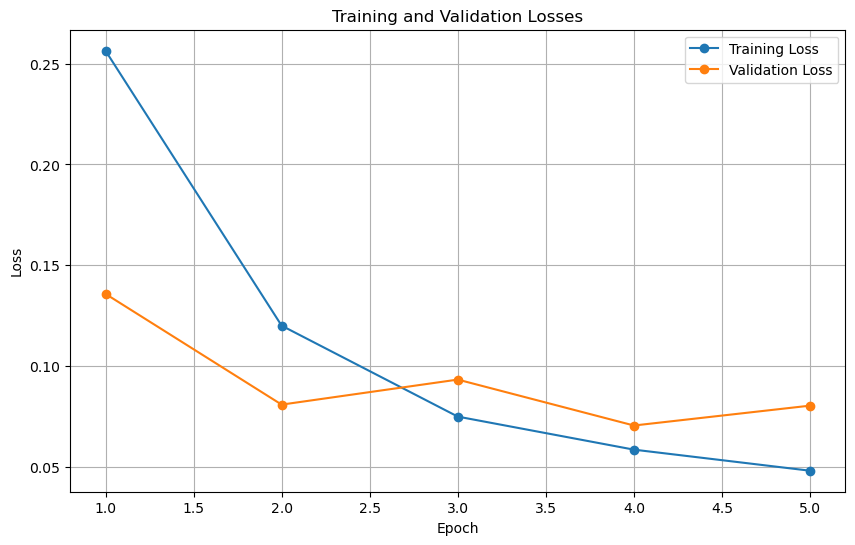


Training completed!
Model saved to spam_transformer.pth


In [21]:
# Main training script
# Load dataset from CSV file
print("Loading data...")
df = pd.read_csv('spam_dataset.csv')

# Convert spam/ham labels to binary values (0/1)
df['Category'] = (df['Category'] == 'spam').astype(int)

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Message'].values, df['Category'].values,
    test_size=0.2, random_state=42
)

# Initialize text preprocessor with vocabulary and sequence length limits
print("Preprocessing data...")
preprocessor = TextPreprocessor(max_vocab_size=10000, max_seq_length=128)
preprocessor.build_vocab(train_texts)

# Create dataset objects for training and validation
train_dataset = SpamDataset(train_texts, train_labels, preprocessor)
val_dataset = SpamDataset(val_texts, val_labels, preprocessor)

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Set up device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize the transformer model - you can experiment with different number of attention heads
# You can also change the number of layers or the max sequence length to see how that affects performance
model = SpamTransformer(
    vocab_size=len(preprocessor.word2idx),
    d_model=64,
    num_heads=4,
    d_ff=256,
    num_layers=2,
    max_seq_length=128
).to(device)

# Set up training parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

# Initialize lists to track losses
train_losses = []
val_losses = []

# Main training loop
print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    # Evaluate on validation set
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Visualize training progress
plot_losses(train_losses, val_losses)

print("\nTraining completed!")

# Save trained model
torch.save(model.state_dict(), 'spam_transformer.pth')
print("Model saved to spam_transformer.pth")

# Questions to think about and future exercises

- Is your validation loss rising again?
- How would you avoid overfitting through early stopping?
- Write a prediction function (run one forward pass through the transformer) to see how well your model predicts the output for an example sentence of your choice.